In [1]:
import pickle as pkl
def unpack(file_path, is_number, freq_var=0):
    with open(file_path, 'rb') as file:
        row_data = pkl.load(file)
#         print(row_data.keys())
        if is_number:
            freq_vars = row_data[0]
            power = np.array(row_data[1])
            freq = np.array(row_data[2][freq_vars[freq_var]][0][0])
            data = np.array([row_data[2][freq_vars[freq_var]][i][1]
                                 for i in range(len(power))])
        else:
            try:
                freq, power = row_data['Frequency [Hz]'], row_data['power [dBm]']
                data = np.array(row_data['data'])
            except:
                freq, power = row_data['Frequency [Hz]'], row_data['Power [dBm]']
                data = np.array(row_data['data'])
            
    return power, data, freq

In [2]:
from S21 import *

In [3]:
import copy
class S21_fit(object):
    
    def __init__(self, power, data, freq, remove_baseline=True, is_plot=True):
        self.S21 = S21(power, data, freq)
        self.remove_baseline = remove_baseline
        self.is_plot = is_plot
        
    def compare_errors(self):
        p = self.S21_mismatch.params
        cut = np.argmin(p.error_abs*p.error_arg*p.error_ellipse*p.error_canonical_arg*p.error_canonical_real)
        return cut
    
    
    def plot_best(self):
        cut = self.compare_errors()
        self.S21.fit_geometrical(cut=cut, is_plot=True)
        
        self.S21_enviroment.fit_canonical_arg(cut=cut, is_plot=True)
        plt.xlabel('Freq, Hz')
        plt.ylabel('Arg(S_21)')
        plt.show()
        
        self.S21_mismatch.fit_canonical_real(cut=cut, is_plot=True)
        plt.xlabel('Freq, Hz')
        plt.ylabel('Real(S_21)')
        plt.show()
        
    
    def fit_notch_port(self):
        self.S21_enviroment = copy.deepcopy(self.S21)
        self.S21_enviroment.remove_background(remove_baseline=self.remove_baseline, is_plot=self.is_plot)
        
        self.S21_mismatch = copy.deepcopy(self.S21_enviroment)
        self.S21_mismatch.remove_mismatch(is_plot=self.is_plot)
        
        self.S21_mismatch.fit_lorentzian(is_plot=self.is_plot)
        
        self.plot_best()
        
        

In [5]:
path = 'D:/LAQS/One Qubit Fit/2023.02.02/STS_FROM_POWER, 30.11.20_raw_data.pkl'
power, data, freq = unpack(file_path=path, is_number=False)
d = S21(power, data, freq)

n = len(d.power)

In [6]:
s = S21_fit(power=power, data=data, freq=freq, is_plot=False)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\users\user\appdata\local\prog

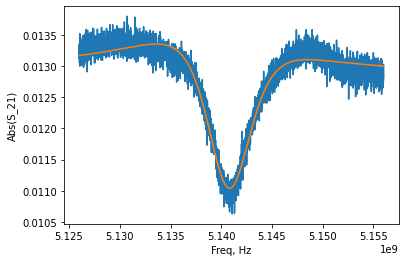

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


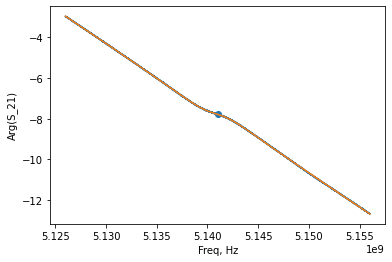

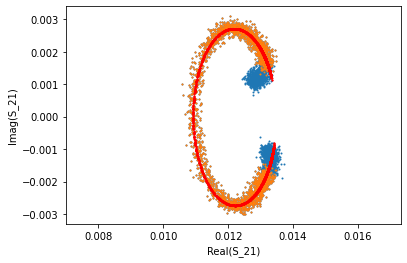

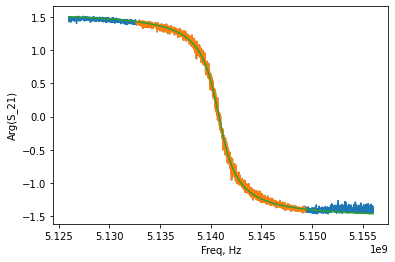

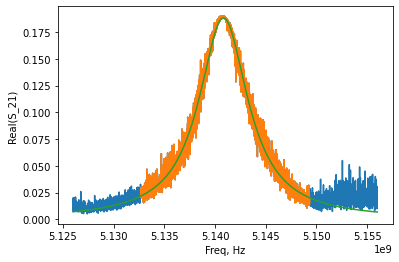

In [7]:
s.fit_notch_port()

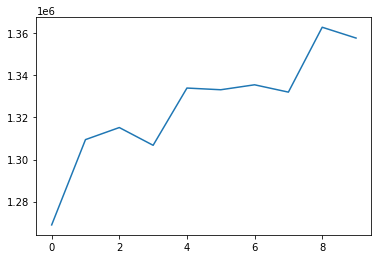

In [10]:
plt.plot(s.S21_mismatch.ig.gamma2[1:])